In [1]:
#Import Modules

#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

import pandas as pd

#advectionGP
from advectionGP.models import AdjointAdvectionDiffusionModel as Model #Model module builds basic parts of the PDE problem, combines other classes into full model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model

#Plotting tools
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Forward Problem

In [2]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,8,3) # lower time
xloc=np.linspace(2,8,4) # x locations
yloc=np.linspace(2,8,4) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+1 # upper time

sensors = FixedSensorModel(X,1) # establish sensor model arguments are sensor locations and spatial averaging

In [13]:
# Run forward model to generate concentration
#u = [0.05,0.] #Advection


k_0 = 0.01 #Diffusion
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[10,10,10])# corners of the grid - in units of space
k = EQ(3, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [50,30,30] # grid size for time, x and y
wind=np.cos(np.linspace(0,6*np.pi,res[1]))*0.05
u=[]
u.append(np.ones(res)*wind) #x direction wind
u.append(np.ones(res)*0.0) # y direction wind
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,u=u,k_0=k_0) #initiate PDE model to build concentration

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
source=m.computeSourceFromPhi(z) # Compute source

source = np.zeros(m.resolution)
#source[0,int(Nx/2)-1,int(Ny/2)-1] = 10.0
source[0,20,:] = 1

concTrain=m.computeConcentration(source) # Compute concentration - runs advection diffusion forward model



In [4]:
# Generate training data
yTrain= m.computeObservations(addNoise='TRUE') # Compute observations with noise uses m.sensormodel for observation locations

# Inverse Problem

In [5]:
N_feat =200 #Number of features used to infer the source
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,u=u,k_0=k_0) #Initiate new model for inference
regress = mInfer.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using inferred distributio

Calculating Adjoints...
47/48 
Calculating Phis...
199/200 


In [6]:
(np.square(np.subtract(source,sourceInfer))).mean() #MSE between ground truth and inferred source

0.005413001042505622

## Plot sources for comparison

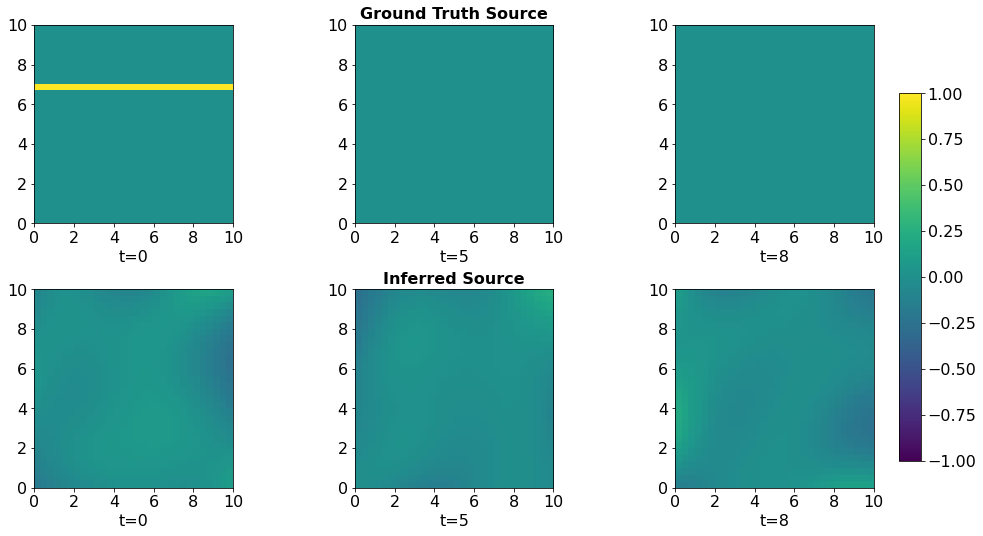

In [7]:
a=np.floor(np.min((np.min(sourceInfer),np.min(source))))
b=np.ceil(np.max((np.max(sourceInfer),np.max(source))))
plt.rcParams["figure.figsize"] = (15,15)
fig = plt.figure()

plt.subplot(331)
im1=plt.imshow(source[0], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=0",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im1,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(332)
im2=plt.imshow(source[16], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=5",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im2,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)
plt.title('Ground Truth Source', fontsize=16, fontweight='bold')

plt.subplot(333)
im3=plt.imshow(source[39], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=8",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)

plt.subplot(334)
im1=plt.imshow(sourceInfer[0], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=0",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im1,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)

plt.subplot(335)
im4=plt.imshow(sourceInfer[16], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=5",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)
#cbar = plt.colorbar(im2,fraction=0.046, pad=0.04)
tick_font_size = 16
#cbar.ax.tick_params(labelsize = tick_font_size)
plt.title('Inferred Source', fontsize=16, fontweight='bold')

plt.subplot(336)
im3=plt.imshow(sourceInfer[39], extent=[0,10,0,10],origin='lower')
plt.xlabel("t=8",fontsize=16)
#plt.ylabel("y",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.clim(a,b)

fig.tight_layout(rect=[0.1, 0.2, 1, 0.95])


fig.subplots_adjust(bottom=0.25)
cbar_ax = fig.add_axes([0.97, 0.52, 0.02, 0.34])
cbar=fig.colorbar(im1, cax=cbar_ax,orientation='vertical')
#cbar = plt.colorbar(im3,fraction=0.046)
tick_font_size = 16
cbar.ax.tick_params(labelsize = tick_font_size)
plt.show()

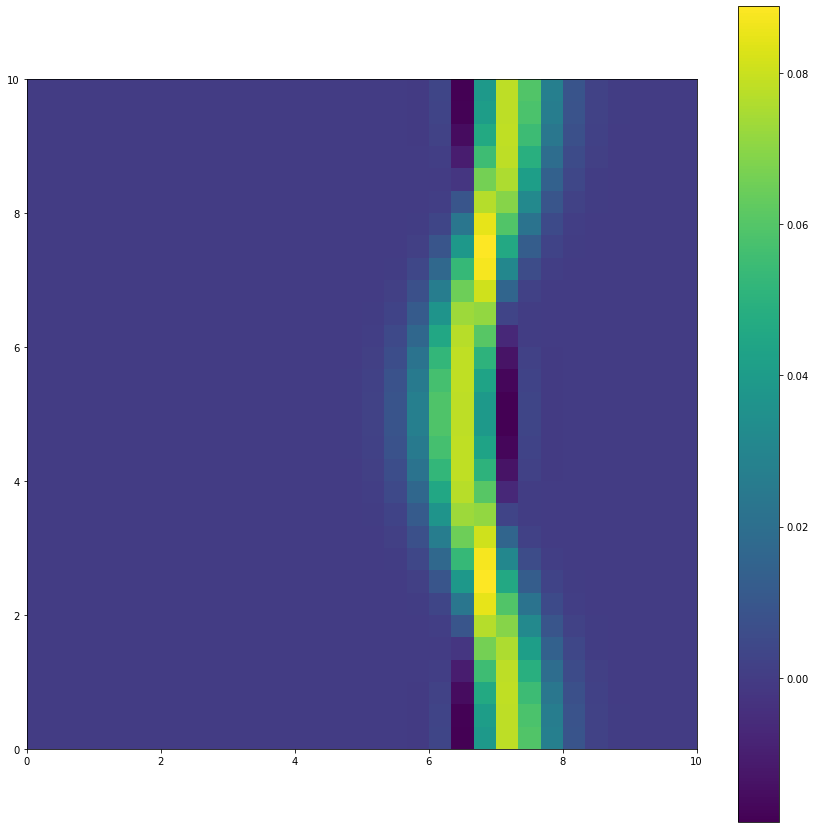

In [8]:
plt.imshow(concTrain[30].T,extent=[0,10,0,10],origin='lower')
plt.colorbar()

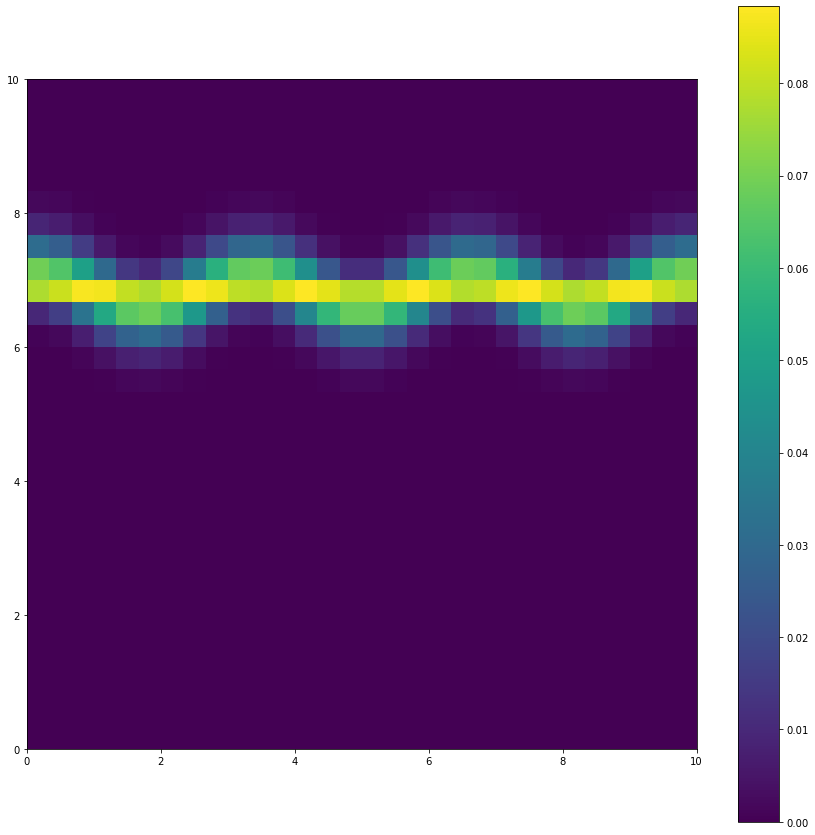

In [14]:
plt.imshow(concTrain[30],extent=[0,10,0,10],origin='lower')
plt.colorbar()

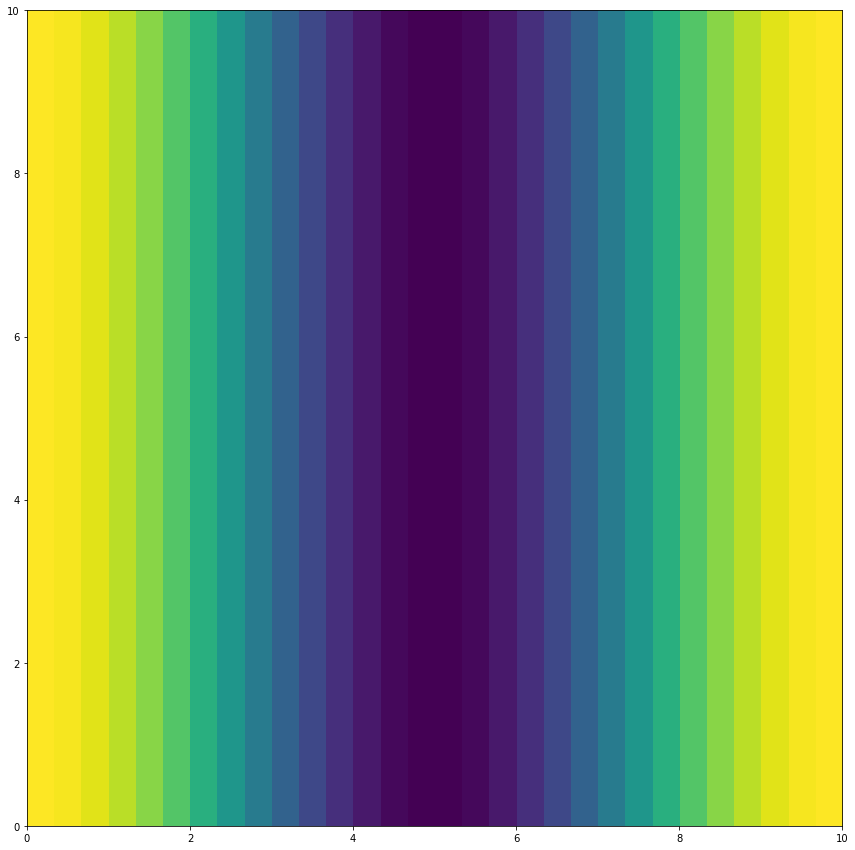

In [10]:
plt.imshow(u[0][0],extent=[0,10,0,10],origin='lower')